In [1]:
import os
import pickle
from collections import OrderedDict

import torch
import data
from options.test_options import TestOptions
from models.pix2pix_model import Pix2PixModel
from util.visualizer import Visualizer
from util import html
from data.base_dataset import BaseDataset, get_params, get_transform

import numpy as np
from PIL import Image

with open('opts.pkl', 'rb') as f:
    opt = pickle.load(f)

In [2]:
class Muse():
    def __init__(self):
        self.model = Pix2PixModel(opt)
        self.model.eval()

    def post_process(self, img):
        img = img.detach().cpu().float().numpy().squeeze()
        image_numpy = (np.transpose(img, (1, 2, 0)) + 1) / 2.0 * 255.0
        image_numpy = np.clip(image_numpy, 0, 255)
        return image_numpy.astype(np.uint8)
    
    def preprocess(self, x):
#         params = get_params(opt, label.size)
#         transform_label = get_transform(opt, params, method=Image.NEAREST, normalize=False)
#         label_tensor = transform_label(label) * 255.0
        label_tensor = torch.FloatTensor(x)[None]
        label_tensor[label_tensor == 255] = opt.label_nc  # 'unknown' is opt.label_nc

        # create one-hot label map
        label_map = label_tensor[None].long()
        bs, _, h, w = label_map.size()
        nc = 184
        
        input_label = torch.FloatTensor(bs, nc, h, w).zero_()
        input_semantics = input_label.scatter_(1, label_map, 1.0)
        return input_semantics
        
    def infer(self, x):
        semantics = self.preprocess(x)
        with torch.no_grad():
            pred = self.model.netG(semantics, z=None)
            image_pred = self.post_process(pred)
            return image_pred

In [3]:
val_label = Image.open('datasets/coco_stuff/val_label/000000001490.png')

In [4]:
muse = Muse()

Network [SPADEGenerator] was created. Total number of parameters: 97.5 million. To see the architecture, do print(network).


In [5]:
import labelMap_pb2
import numpy as np
import pickle
import PIL.Image as Image
import io
import cv2

with open('./example_pickle_v2.pkl', 'rb') as f:
    pb = pickle.load(f)

In [6]:
assert (pb.height * pb.width) == len(pb.pixel)

In [10]:
# np.array(pb.pixel[0].internal_array
h = pb.height
w = pb.width

labelMap = np.array(pb.pixel).reshape(h, w)

labelMap.shape

(834, 1194)

In [11]:
np.unique(labelMap)

array([  0,  10,  64, 120])

In [12]:
# im = Image.open(io.BytesIO(bytearray(pb.pixel)))
# arr = np.asarray(im)
# label = arr.transpose(2,0,1)[3:].squeeze()
# label = cv2.resize(label, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

In [14]:
# arr.transpose(2,0,1)[3]

In [18]:
# def show_label_map(img):
#     plt.imshow(img, cmap='gray', vmin=0, vmax=255)
#     plt.show()

# def process_pb(pb: labelMap_pb2.Labelmapbuffer):
#     """ Convert Protocal buffer png
#     """
# #     im = Image.open(io.BytesIO(bytearray(pb.pixel)))
#     arr = np.asarray(im)
#     label = arr.transpose(2,0,1)[0].squeeze()
# #     print(np.unique(label))
#     label = cv2.resize(label, dsize=(256, 256))
#     return label, arr,

In [19]:
# xbs, arr, im = process_pb(pb)
# xbs = np.clip(xbs, 254,255)
# # xbs[xbs != 255] = 1. 
# xbs[xbs == 254] = 64.
# xbs[xbs == 255] = 64.

In [21]:
# im.size

In [42]:
labelMap.shape[0] / 256

3.2578125

In [46]:
labelMap.shape[0]/2

417.0

In [25]:
# cv2.resize(yhat, dsize=(w, h), interpolation=cv2.INTER_CUBIC).shape

/Users/patricio/code/muse/__venv__/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


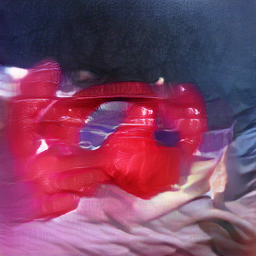

In [26]:
yhat = muse.infer(labelMap)
Image.fromarray(yhat)

In [27]:
generated_image = Image.fromarray(cv2.resize(yhat, dsize=(w, h), interpolation=cv2.INTER_CUBIC) )
# type(generated_image)

In [28]:
resized_yhat = cv2.resize(yhat, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
png_encoded = cv2.imencode('.png', resized_yhat[..., [2,1,0]])[1]

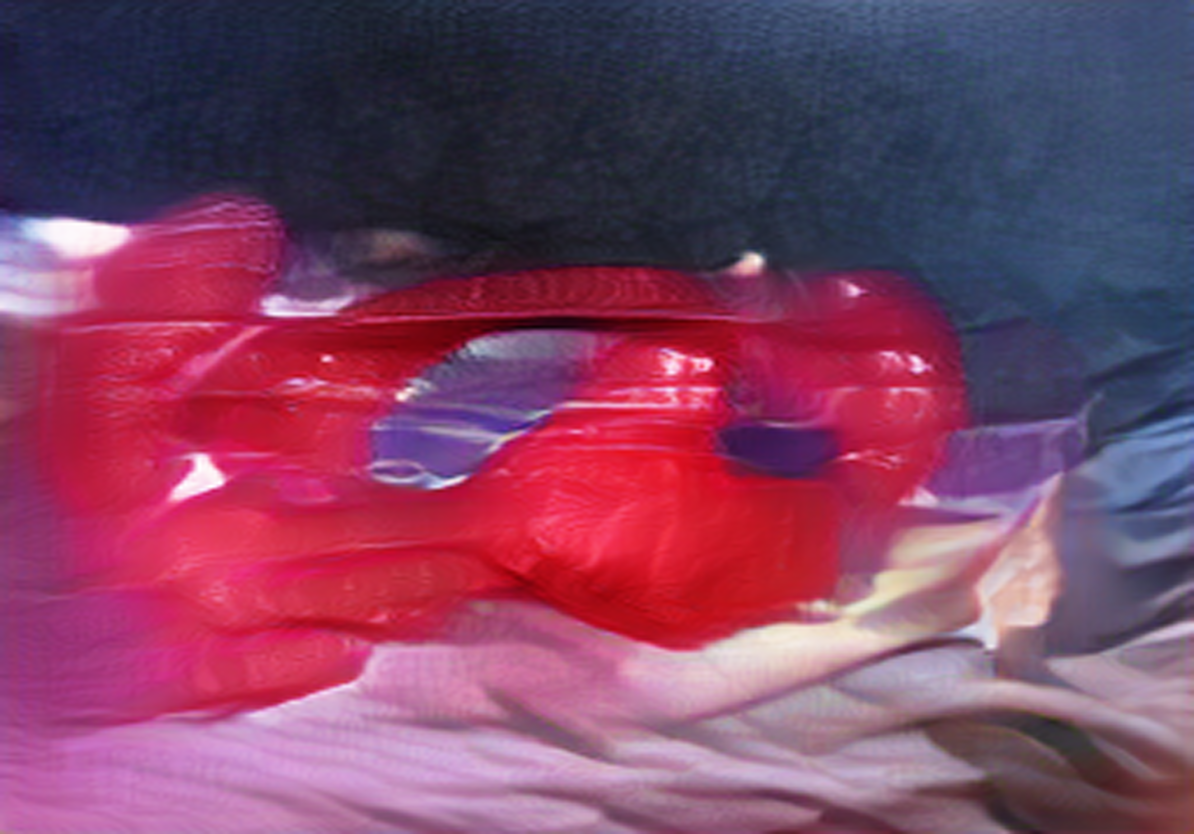

In [29]:
Image.open(io.BytesIO(bytearray(png_encoded )))

In [31]:
opt.label_nc

182

In [32]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

model = muse.model.netG
model.eval()
# example = torch.rand(1, 3, 224, 224)
example = muse.preprocess(labelMap)
# example
traced_script_module = torch.jit.trace(model, example)
torchscript_model_optimized = optimize_for_mobile(traced_script_module)
torchscript_model_optimized.save("model.pt")

/Users/patricio/code/muse/__venv__/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [33]:
# torch.onnx.export(model,               # model being run
#                   example,                         # model input (or a tuple for multiple inputs)
#                   "muse.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
#                                 'output' : {0 : 'batch_size'}})

In [34]:
# import coremltools as ct

In [36]:
#
# Unknown type __torch__.torch.classes.xnnpack.Conv2dOpContext encountered in graph lowering. This type is not supported in ONNX export.
#
#


# model_coreml = ct.convert(
#     torchscript_model_optimized,
#     inputs=[ct.ImageType(name="input_1", shape=example.shape)], #name "input_1" is used in 'quickstart'
# #     classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 4 was performed
# )

RuntimeError: Unknown type __torch__.torch.classes.xnnpack.Conv2dOpContext encountered in graph lowering. This type is not supported in ONNX export.

In [78]:
ct.converters.

<module 'coremltools.converters' from '/Users/patricio/code/muse/__venv__/lib/python3.7/site-packages/coremltools/converters/__init__.py'>